Using data from the [Lending Club](https://www.lendingclub.com/), a US peer-to-peer lending company.  Borrowers on the platform can borrow between `$`1000 to `$`40,000 in the form of unsecured personal loans, for a term of either three or five years.

Investors can browse the loan applications and choose to finance the loans based on the credit history of the borrower, the amount of the loan, the loan grade, and the purpose of the loan.  Investors earn money through interested paid on the loans, and Lending Club makes money from loan origination fees and service charges.

We will be using is from 2019 and is publicly available on the [Lending Club Website](https://www.lendingclub.com/statistics/additional-statistics?) (must make an account).  A data dictionary is also available.

# Imports

In [1]:
# Importing Libraries
'''Main'''
import numpy as np
import pandas as pd
import glob, os, re, time

'''Data Visualization'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
%matplotlib inline

'''Data Prep'''
from sklearn.impute import SimpleImputer
from sklearn import preprocessing as pp

'''Clustering Models'''
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet, fcluster
from scipy.spatial.distance import pdist
import hdbscan

'''Model Evaluation'''
from sklearn.metrics import adjusted_rand_score, silhouette_score

'''Dimensionality Reduction Algorithms'''
from sklearn.decomposition import PCA


---
# Data

## Data Import

In [2]:
files = glob.glob(os.path.join('data', '*.zip'))
data = pd.concat((pd.read_csv(file, compression='zip', header=1, low_memory=False) for file in files), ignore_index=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518115 entries, 0 to 518114
Columns: 150 entries, id to settlement_term
dtypes: float64(112), object(38)
memory usage: 592.9+ MB


In [3]:
data.shape

(518115, 150)

## Column Filtering

In [4]:
data.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'orig_projected_additional_accrued_interest',
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'debt_settlement_flag', 'debt_settlement_flag_date',
       'settlement_status', 'settlement_date', 'settlement_amount',
       'settlement_percentage', 'settlement_term'],
      dtype='object', length=150)

I don't really need all these columns, so we'll narrow them down.

In [5]:
print('old shape: ', data.shape)
# Select columns to keep
columnsToKeep = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                 'int_rate','installment','grade','sub_grade', \
                 'emp_length','home_ownership','annual_inc', \
                 'verification_status','pymnt_plan','purpose', \
                 'addr_state','dti','delinq_2yrs','earliest_cr_line', \
                 'mths_since_last_delinq','mths_since_last_record', \
                 'open_acc','pub_rec','revol_bal','revol_util', \
                 'total_acc','initial_list_status','out_prncp', \
                 'out_prncp_inv','total_pymnt','total_pymnt_inv', \
                 'total_rec_prncp','total_rec_int','total_rec_late_fee', \
                 'recoveries','collection_recovery_fee','last_pymnt_d', \
                 'last_pymnt_amnt']

data = data.loc[:,columnsToKeep]
print('new shape: ', data.shape)

old shape:  (518115, 150)
new shape:  (518115, 37)


- **loan_amnt** : The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.
- **funded_amnt** : The total amount committed to that loan at that point in time.
- **funded_amnt_inv** : The total amount committed by investors for that loan at that point in time.
- **term** : The number of payments on the loan. Values are in months and can be either 36 or 60.
- **int_rate** : Interest Rate on the loan
- **installment** : The monthly payment owed by the borrower if the loan originates.
- **grade** : LC assigned loan grade
- **sub_grade** : LC assigned loan subgrade
- **emp_length** : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.
- **home_owndership** : The home ownership status provided by the borrower during registration. Our values are: RENT, OWN, MORTGAGE, OTHER. 
- **annual_inc** : The self-reported annual income provided by the borrower during registration.
- **verification_status** : The status of the loan during the listing period. Values: APPROVED, NOT_APPROVED.
- **pymnt_plan** : Indicates if a payment plan has been put in place for the loan
- **purpose** : A category provided by the borrower for the loan request. 
- **addr_state** : The state provided by the borrower in the loan application
- **dti** : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
- **delinq_2yrs** : The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
- **earliest_cr_line** : The date the borrower's earliest reported credit line was opened
- **mths_since_last_delinq** : The number of months since the borrower's last delinquency.
- **mths_since_last_record** : The number of months since the last public record.
- **open_acc** : The number of open credit lines in the borrower's credit file.
- **pub_rec** : Number of derogatory public records
- **revol_bal** : Total credit revolving balance
- **revol_util** : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
- **total_acc** : The total number of credit lines currently in the borrower's credit file
- **initial_list_status** : The initial listing status of the loan. Possible values are – W, F
- **out_prncp** : Remaining outstanding principal for total amount funded
- **out_prncp_inv** : Remaining outstanding principal for portion of total amount funded by investors
- **total_pymnt** : Payments received to date for total amount funded
- **total_pymnt_inv** : Payments received to date for portion of total amount funded by investors
- **total_rec_prncp** : Principal received to date
- **total_rec_int** : Interest received to date
- **total_rec_late_fee** : Late fees received to date
- **recoveries** : post charge off gross recovery
- **collection_recovery_fee** : post charge off collection fee
- **last_pymnt_d** : Last month payment was received
- **last_pymnt_amnt** : Last total payment amount received

In [6]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,...,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt
0,5000.0,5000.0,5000.0,36 months,13.90%,170.65,C,C1,NaN,OWN,...,3164.76,2552.03,2552.03,1835.24,716.79,0.0,0.0,0.0,Jun-2020,170.65
1,6500.0,6500.0,6475.0,36 months,8.81%,206.13,A,A5,10+ years,OWN,...,0.00,7015.28,6988.30,6500.00,515.28,0.0,0.0,0.0,Apr-2020,4754.21
2,24000.0,24000.0,24000.0,60 months,13.90%,557.20,C,C1,10+ years,MORTGAGE,...,20427.69,7206.53,7206.53,3572.31,3634.22,0.0,0.0,0.0,Jun-2020,557.20
3,18500.0,18500.0,18500.0,60 months,14.74%,437.60,C,C2,NaN,MORTGAGE,...,15121.23,6533.70,6533.70,3378.77,3154.93,0.0,0.0,0.0,Jul-2020,437.60
4,24000.0,24000.0,24000.0,60 months,20.00%,635.86,D,D2,8 years,MORTGAGE,...,20017.99,9484.57,9484.57,3982.01,5502.56,0.0,0.0,0.0,Jun-2020,635.86


## D-type and Nulls Cleaning

In [7]:
# Transform features from string to numeric
for i in ["term","int_rate","emp_length","revol_util"]:
    data.loc[:,i] = \
        data.loc[:,i].apply(lambda x: re.sub("[^0-9]", "", str(x)))
    data.loc[:,i] = pd.to_numeric(data.loc[:,i])

# Determine which features are numerical
numericalFeats = [x for x in data.columns if data[x].dtype != 'object']

nanCounter = np.isnan(data.loc[:,numericalFeats]).sum()
nanCounter

loan_amnt                       8
funded_amnt                     8
funded_amnt_inv                 8
term                            8
int_rate                        8
installment                     8
emp_length                  46259
annual_inc                      8
dti                          1153
delinq_2yrs                     8
mths_since_last_delinq     292561
mths_since_last_record     462994
open_acc                        8
pub_rec                         8
revol_bal                       8
revol_util                    682
total_acc                       8
out_prncp                       8
out_prncp_inv                   8
total_pymnt                     8
total_pymnt_inv                 8
total_rec_prncp                 8
total_rec_int                   8
total_rec_late_fee              8
recoveries                      8
collection_recovery_fee         8
last_pymnt_amnt                 8
dtype: int64

In [8]:
# Impute NaNs with mean 
fillWithMean = ['loan_amnt','funded_amnt','funded_amnt_inv','term', \
                'int_rate','installment','emp_length','annual_inc',\
                'dti','open_acc','revol_bal','revol_util','total_acc',\
                'out_prncp','out_prncp_inv','total_pymnt', \
                'total_pymnt_inv','total_rec_prncp','total_rec_int', \
                'last_pymnt_amnt']

# Impute NaNs with zero
fillWithZero = ['delinq_2yrs','mths_since_last_delinq', \
                'mths_since_last_record','pub_rec','total_rec_late_fee', \
                'recoveries','collection_recovery_fee']

# Perform imputation
im = SimpleImputer(strategy='mean')   
data.loc[:,fillWithMean] = im.fit_transform(data[fillWithMean])

data.loc[:,fillWithZero] = data.loc[:,fillWithZero].fillna(value=0,axis=1)

# Check for NaNs one last time
nanCounter = np.isnan(data.loc[:,numericalFeats]).sum()
nanCounter

loan_amnt                  0
funded_amnt                0
funded_amnt_inv            0
term                       0
int_rate                   0
installment                0
emp_length                 0
annual_inc                 0
dti                        0
delinq_2yrs                0
mths_since_last_delinq     0
mths_since_last_record     0
open_acc                   0
pub_rec                    0
revol_bal                  0
revol_util                 0
total_acc                  0
out_prncp                  0
out_prncp_inv              0
total_pymnt                0
total_pymnt_inv            0
total_rec_prncp            0
total_rec_int              0
total_rec_late_fee         0
recoveries                 0
collection_recovery_fee    0
last_pymnt_amnt            0
dtype: int64

## Feature Engineering and More Cleaning

In [9]:
# Feature engineering
# Typically ratios between loan amount, revolving balance, payments, 
# and the borrower's annual income
data['installmentOverLoanAmnt'] = data.installment/data.loan_amnt
data['loanAmntOverIncome'] = data.loan_amnt/data.annual_inc
data['revol_balOverIncome'] = data.revol_bal/data.annual_inc
data['totalPymntOverIncome'] = data.total_pymnt/data.annual_inc
data['totalPymntInvOverIncome'] = data.total_pymnt_inv/data.annual_inc
data['totalRecPrncpOverIncome'] = data.total_rec_prncp/data.annual_inc
data['totalRecIncOverIncome'] = data.total_rec_int/data.annual_inc

newFeats = ['installmentOverLoanAmnt','loanAmntOverIncome', \
            'revol_balOverIncome','totalPymntOverIncome', \
           'totalPymntInvOverIncome','totalRecPrncpOverIncome', \
            'totalRecIncOverIncome']

For some reason, issues were happening later on.  Found out some newly created columns were becoming 'null' aka positive infinity.

In [10]:
print('NaN in numericalFeats: ', np.any(np.isnan(data.loc[:,numericalFeats])))

print('NaN in newFeats: ', np.any(np.isnan(data.loc[:,newFeats])))

data.loc[:,newFeats].max()

NaN in numericalFeats:  False
NaN in newFeats:  True


installmentOverLoanAmnt    0.04295
loanAmntOverIncome             inf
revol_balOverIncome            inf
totalPymntOverIncome           inf
totalPymntInvOverIncome        inf
totalRecPrncpOverIncome        inf
totalRecIncOverIncome          inf
dtype: float64

In [11]:
print('old data shape: ', data.shape)
with pd.option_context('mode.use_inf_as_na', True):
    # Dropping the rows with nan  
    # (or inf) values 
    data.dropna(inplace=True)
    
print('NaN in numericalFeats: ', np.any(np.isnan(data.loc[:,numericalFeats])))

print('NaN in newFeats: ', np.any(np.isnan(data.loc[:,newFeats])))

print('new data shape: ', data.shape)

old data shape:  (518115, 44)
NaN in numericalFeats:  False
NaN in newFeats:  False
new data shape:  (516108, 44)


---
# Feature Selection and Scaling

## Features

In [12]:
# Select features for training
numericalPlusNewFeats = numericalFeats+newFeats
X_train = data.loc[:,numericalPlusNewFeats]

# Scale data
sX = pp.StandardScaler()
X_train.loc[:,:] = sX.fit_transform(X_train)

In [13]:
X_train.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'installmentOverLoanAmnt',
       'loanAmntOverIncome', 'revol_balOverIncome', 'totalPymntOverIncome',
       'totalPymntInvOverIncome', 'totalRecPrncpOverIncome',
       'totalRecIncOverIncome'],
      dtype='object')

## Labels

In [14]:
data.grade.value_counts(dropna=False)

A    165175
B    150906
C    121873
D     74726
E      3375
F        36
G        17
Name: grade, dtype: int64

I see the grades are imbalanced, but as this is unsupervised project, I have to assume we can't know.

In [15]:
# Designate labels for evaluation
labels = data.grade
labels.unique()

array(['C', 'A', 'D', 'B', 'E', 'G', 'F'], dtype=object)

In [16]:
# Fill missing labels if there are any
labels = labels.fillna(value="Z")

# Convert labels to numerical values
lbl = pp.LabelEncoder()
lbl.fit(list(labels.values))
labels = pd.Series(data=lbl.transform(labels.values), name='grade')

# Store as y_train
y_train = labels

In [17]:
# View the changes
labelsOriginalVSNew = pd.concat([labels, data.grade],axis=1)
labelsOriginalVSNew.head(5)

,grade,grade
0,2.0,C
1,0.0,A
2,2.0,C
3,2.0,C
4,3.0,D


In [18]:
# Compare loan grades with interest rates
interestAndGrade = pd.DataFrame(data=[data.int_rate,labels])
interestAndGrade = interestAndGrade.T

interestAndGrade.groupby("grade").mean()

,int_rate
grade,
0.0,1285.583177
1.0,1286.537482
2.0,1288.398079
3.0,1290.670952
4.0,1243.752083
5.0,1351.028571
6.0,1209.294118


Now that we have X_train with all 34 numberical features and y_train with numerical loan grades (used only to validate the results).

Presumably, borrowers that are similar to each other and grouped together should have similar credit profiles.  Aka, their creditworthiness should be similar.

## Sampling 10,000

In [19]:
# Random sample of 10,000 out of ~510,000
np.random.seed(123)

indices = np.random.choice(data.shape[0],10000)
X = X_train.iloc[indices] / 255.0
y = y_train.iloc[indices]

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

print(X.shape, y.shape)

(10000, 34) (10000,)


---

# Analyzing Clusters

The clusters we want should be filled with borrowers of similar numerical loan grade, which we will validate using the numerical loan grades we set aside in `y`.  The higher the percentage of borrowers that have the most frequently occuring numerical loan grade in each and every cluster, the better the clustering application.

For example, consider a cluster with 100 borrowers.  If 30 borrowers have the numerical grade of 0, 25 borrowers have a loan grade of 1, 20 borrowers have a loan grade of 2, and the remaining borrowers have loan grades ranging from 3 to 7, we would say that the cluster has a 30% accuracy, given that the most frequently occuring lonan grade for that cluster applies to just 30% of the borrowers in that cluster.

To analyze future clusters:

In [20]:
def analyzeCluster(clusterDF, labelsDF):
    countByCluster = pd.DataFrame(data=clusterDF['cluster'].value_counts())
    countByCluster.reset_index(inplace=True, drop=False)
    countByCluster.columns = ['cluster', 'clusterCount']
    
    preds = pd.concat([labelsDF, clusterDF], axis=1)
    preds.columns = ['trueLabel', 'cluster']
    
    countByLabel = pd.DataFrame(data=preds.groupby('trueLabel').count())
    
    countMostFreq = pd.DataFrame(data=preds.groupby('cluster').agg(lambda x : x.value_counts().iloc[0]))
    countMostFreq.reset_index(inplace=True, drop=False)
    countMostFreq.columns = ['cluster', 'countMostFrequent']
    
    accuracyDF = countMostFreq.merge(countByCluster, left_on='cluster', right_on='cluster')
    
    overallAccuracy = accuracyDF.countMostFrequent.sum()/accuracyDF.clusterCount.sum()
    
    accuracyByLabel = accuracyDF.countMostFrequent/accuracyDF.clusterCount
    
    return countByCluster, countByLabel, countMostFreq, accuracyDF, overallAccuracy, accuracyByLabel

# Models

In [21]:
# PCA Dimensionality Reduction
def pca_dr(n=2, X=X):
    time_start = time.time()
    return PCA(n_components=n).fit_transform(X)
    print('PCA done!  Time elapsed: {} seconds'.format(time.time()-time_start))
    
# tSNE Dimensionality Reduction
def tsne_dr(n=2, v=1, p=40, n_iter=300, X=X):
    time_start = time.time()
    return TSNE(n_components=n, verbose=v, perplexity=p, n_iter=n_iter).fit_transform(X)
    print('t-SNE done!  Time elapsed: {} seconds'.format(time.time()-time_start))
    
# UMAP Dimensionality Reduction
def umap_dr(n=5, d=0.3, m='correlation', X=X):
    time_start = time.time()
    return umap.UMAP(n_neighbors=n, min_dist=d, metric=m).fit_transform(X)
    print('UMAP done!  Time elapsed: {} seconds'.format(time.time()-time_start))

Let's run an experimet where K ranges from 10 to 30 and plot the results of the accuracy measure we defined.

<AxesSubplot:>

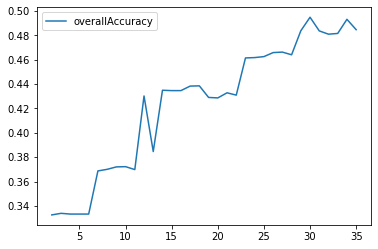

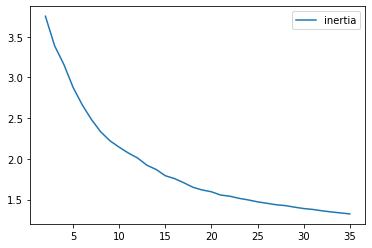

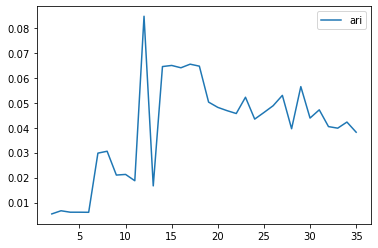

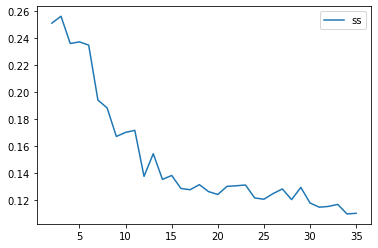

In [22]:
n_clusters = 10
n_init = 10
max_iter = 300
tol = 0.0001
random_state = 123
cluster_range = range(2,36)

kmeans = KMeans(n_clusters=n_clusters,
                n_init=n_init,
                max_iter=max_iter,
                tol=tol,
                random_state=random_state)
# Inertia
kMeans_inertia = pd.DataFrame(data=[],
                              index=cluster_range,
                              columns=['inertia'])
# Overall Accuracy
overallAccuracy_kMeansDF = pd.DataFrame(data=[],
                                        index=cluster_range,
                                        columns=['overallAccuracy'])
# ARI
ari_KMeansDF = pd.DataFrame(data=[],
                            index=cluster_range,
                            columns=['ari'])
# Silhouette Score
ss_KMeansDF = pd.DataFrame(data=[],
                            index=cluster_range,
                            columns=['ss'])
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters,
                    n_init=n_init,
                    max_iter=max_iter,
                    tol=tol,
                    random_state=random_state)
    kmeans.fit(X)
    kMeans_inertia.loc[n_clusters] = kmeans.inertia_
    cluster = kmeans.predict(X)
    cluster_df = pd.DataFrame(data=cluster,
                         index=X.index,
                         columns=['cluster'])
    
    countByCluster_kMeans, countByLabel_kMeans, \
    countMostFreq_kMeans, accuracyDF_kMeans, \
    overallAccuracy_kMeans, accuracyByLabel_kMeans = \
    analyzeCluster(cluster_df, y)
    
    overallAccuracy_kMeansDF.loc[n_clusters] = overallAccuracy_kMeans
    
    ari_KMeansDF.loc[n_clusters] = adjusted_rand_score(y, cluster)
    ss_KMeansDF.loc[n_clusters] = silhouette_score(X, cluster, metric='euclidean')
overallAccuracy_kMeansDF.plot()
kMeans_inertia.plot()
ari_KMeansDF.plot()
ss_KMeansDF.plot()

As we can see from overallAccuracy, the accuracy is best around 30 clusters and levels out there at aproximately 49% accuracy.

Inertia drops very gradually and consistently so there's never really an elbow to determine a clear number of clusters.

ARI shows it doesn't change much after 15 clusters.  Same with Silhoette Score.

Let's take a look at what percentage of accuracy we have for each cluster.

In [23]:
accuracyByLabel_kMeans

0     0.438053
1     0.473413
2     0.483283
3     0.629063
4     0.341902
5     0.321168
6     1.000000
7     0.345029
8     0.750000
9     1.000000
10    0.394737
11    0.508772
12    0.496072
13    0.611247
14    0.400000
15    0.453875
16    0.394737
17    0.390093
18    0.333333
19    0.277567
20    0.449704
21    0.280000
22    0.333333
23    0.389155
24    0.515625
25    0.679641
26    0.524528
27    0.446764
28    0.625592
29    0.467577
30    0.576923
31    0.713666
32    0.400000
33    0.578947
34    0.563877
dtype: float64

For the 35 clusters, we see varying levels of accuracy, ranging anywhere from 27% to 100%.  Lets check out each cluster.

In [24]:
accuracyDF_kMeans

,cluster,countMostFrequent,clusterCount
0,0,99,226
1,1,276,583
2,2,159,329
3,3,329,523
4,4,133,389
5,5,44,137
6,6,1,1
7,7,59,171
8,8,3,4
9,9,1,1


We see why certain clusters were 100% accurate: they're cluster-size of 1.

Starting point to build a clustering application to automatically assign new borrowers that apply for a Lending Cllub loan into a pre-existing group based on how similar they are to the other borrowers.

# Hierarchical Clustering

In [25]:
train_index = range(0, len(X))

# Principal Component Analysis

n = len(X.columns) #n_components
whiten = False
rs = 123 # random_state

pca = PCA(n_components=n, whiten=whiten, random_state=rs)

X_PCA = pca.fit_transform(X)
X_PCA_df = pd.DataFrame(data=X_PCA, index=train_index)

In [26]:
Z = fastcluster.linkage_vector(X, method='ward', metric='euclidean')
Z_df = pd.DataFrame(data=Z, columns=['clusterOne', 
                                    'clusterTwo', 
                                    'distance', 
                                    'newClusterSize'])

In [27]:
distance_threshold = 0.175
clusters = fcluster(Z, distance_threshold, criterion = 'distance')
X_hierClustered = pd.DataFrame(data=clusters,
                               index=X_PCA_df.index,
                               columns=['cluster'])
print("Number of distinct clusters: ", len(X_hierClustered['cluster'].unique()))

Number of distinct clusters:  32


In [28]:
countByCluster_hierClust, countByLabel_hierClust, countMostFreq_hierClust, \
accuracyDF_hierClust, overallAccuracy_hierClust, accuracyByLabel_hierClust = \
analyzeCluster(X_hierClustered, y)
print('Overall accuracy from hierarchical clustering: ', overallAccuracy_hierClust)

Overall accuracy from hierarchical clustering:  0.4416


In [29]:
print('ARI: ', adjusted_rand_score(y, clusters))
print('Silhouette Score: ', silhouette_score(X, clusters, metric='euclidean'))

ARI:  0.031174411715960332
Silhouette Score:  0.07110083374734891


In [30]:
accuracyByLabel_hierClust

0     0.368110
1     0.333333
2     0.316489
3     0.416667
4     0.578947
5     0.475806
6     0.346032
7     0.375000
8     0.479058
9     0.705600
10    0.377778
11    0.402778
12    0.632629
13    0.454121
14    0.400000
15    0.363636
16    0.333333
17    0.345882
18    0.348783
19    0.333333
20    0.464286
21    0.750000
22    0.269231
23    0.330779
24    0.555556
25    0.630058
26    0.576832
27    0.429224
28    0.383721
29    0.372881
30    0.265823
31    1.000000
dtype: float64

Again, we can see percentage ranges from 26% to 100%, with the 100% because it's a cluster-size of 1.

In [31]:
accuracyDF_hierClust

,cluster,countMostFrequent,clusterCount
0,1,187,508
1,2,30,90
2,3,119,376
3,4,20,48
4,5,11,19
5,6,118,248
6,7,109,315
7,8,42,112
8,9,183,382
9,10,441,625


#  HDBSCAN Application

In [32]:
min_cluster_size = 20
min_samples = 20
alpha = 1.0
cluster_selection_method = 'leaf'

hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                      min_samples=min_samples,
                      alpha=alpha,
                      cluster_selection_method=cluster_selection_method)

X_hdbscanClustered = hdb.fit_predict(X)
X_hdbscanClustered_df = pd.DataFrame(data=X_hdbscanClustered,
                                     index=X.index,
                                     columns=['cluster'])
countByCluster_hdbscan, countByLabel_hdbscan, \
countMostFreq_hdbscan, accuracyDF_hdbscan, \
overallAccuracy_hdbscan, accuracyByLabel_hdbscan = \
analyzeCluster(X_hdbscanClustered_df, y)

print('Overall accuracy from hierarchical clustering: ', overallAccuracy_hierClust)
print('ARI: ', adjusted_rand_score(y, X_hdbscanClustered))
print('Silhouette Score: ', silhouette_score(X, X_hdbscanClustered, metric='euclidean'))

Overall accuracy from hierarchical clustering:  0.4416
ARI:  0.05254816559276286
Silhouette Score:  0.08084351789502861


In [33]:
accuracyByLabel_hdbscan

0    0.256751
1    0.455224
2    0.449102
3    0.438173
4    0.393836
5    0.479167
dtype: float64

My increasing the minimum cluster-size, we can get similar results from only 6 clusters.

In [34]:
accuracyDF_hdbscan

,cluster,countMostFrequent,clusterCount
0,-1,580,2259
1,0,61,134
2,1,225,501
3,2,2197,5014
4,3,805,2044
5,4,23,48


From the cluster dataframe, we can see almost a quarter of the data was not grouped at all.  ARI and Silhouette Scores are a smidgen higher compared to previous methods.  Pretty sure results can be improved.